# I. Lý thuyết

1) Transfer Learning thường được thực hiện trên hai dữ liệu nguồn (huấn luyện mô hình nguồn) và dữ liệu đích (huấn luyện mô hình đích) thế nào ?


A. Dữ liệu nguồn và dữ liệu đích có sự liên quan tới nhau. Những đặc trưng trong dữ liệu đích xuất hiện ở những dữ liệu nguồn.

B. Dữ liệu nguồn có số lượng classes lớn hơn dữ liệu đích.

C. Kích thước của dữ liệu nguồn rất nhỏ.

D. Dữ liệu đích ít liên quan tới dữ liệu nguồn.

Đáp án A

2) Khi nào thì chúng ta nên thực hiện fine tuning trên toàn bộ các layers của mô hình đích ?

A. Khi hai dữ liệu nguồn và đích có mức độ tương đồng cao và dữ liệu đích có kích thước lớn.

B. Khi hai dữ liệu nguồn và đích có mức độ tương đồng cao và dữ liệu đích có kích thước nhỏ.

C. Dữ liệu đích có kích thước nhỏ và dữ liệu mục tiêu có kích thước lớn.

D. Cả hai dữ liệu đích và mục tiêu đều có kích thước nhỏ.

Đáp án A

3) Các phương pháp augmentation nào sẽ kết hợp nội dung từ hai ảnh lẫn nhau và tạo ra một nhãn mềm (_soft label_) cho ảnh?

A. Rotation, Random Crop, MixUp

B. Bright Constrast, Color Shift, Addition Noise

C. CutMix, MixUp

D. Flip, Information Loss 

Đáp án C

4) Quá trình xây dựng một mô hình AI trong dự án là một chu trình Machine Learning Cycle kế hợp giữa huấn luyện và gán nhãn dữ liệu. Để tiết kiệm chi phí gán nhãn chúng ta nên sử dụng phương pháp nào ?

A. Lấy mẫu ngẫu nhiên từ tập unlabeled dataset để thực hiện gán nhãn.

B. Sử dụng Active Learning để lựa chọn mẫu mang lại thông tin giúp cải thiện nhiều nhất cho hiệu suất mô hình.

C. Lựa chọn mô hình pretrained lớn nhất có thể.

D. Chỉ lựa các dữ liệu có thông tin rõ ràng, có thể phân biệt được bởi con người.

Đáp án B

5) Mô hình lớn thường đạt độ chính xác cao nhưng không deploy được trên các thiết bị edge device, IoT,... Trong khi mô hình nhỏ có thể deploy được nhưng thường có độ chính xác thấp. Phương pháp nào có thể giúp mô hình nhỏ cải thiện được độ chính xác ? Có thể lựa chọn nhiều đáp án.

A. Sử dụng active learning để lựa chọn các mẫu đại diện cho tổng thể để huấn luyện mô hình nhỏ.

B. Áp dụng augmentation để huấn luyện mô hình nhỏ.

C. Fine tuning các layers của mô hình lớn sang mô hình nhỏ.

D. Sử dụng knowledge distillation để chuyển giao tri thức từ mô hình lớn sang mô hình nhỏ.

Đáp án B,C,D

# II. Thực hành

6) Từ bộ dữ liệu [Dog and Cat](https://www.kaggle.com/c/dog-vs-cat-classification/data), hãy huấn luyện một mô hình large (chẳng hạn ResNet50) bằng cách fine-tuning lại các trọng số từ pretrained model của bộ dữ liệu ImageNet. Huấn luyện trên 5 epochs.

7) Hãy huấn luyện một mô hình small (chẳng hạn MobileNetV3) không sử dụng pretrained model trên 1 epochs.

8) Sử dụng mô hình large làm teacher để cải thiện mô hình small là student theo phương pháp knowledge distillation.

9) Áp dụng thêm các kĩ thuật data augmentation kết hợp ảnh khác nhãn để tạo thành nhãn mềm và huấn luyện cải thiện tiếp model student.

10) Giả định cần huấn luyện tiếp mô hình student với các dữ liệu mới chưa được gán nhãn. Hãy xây dựng một kĩ thuật lựa chọn mẫu dựa trên đánh giá uncertainty.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input,BatchNormalization
import tensorflow as tf
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
import os
import numpy as np
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from keras.regularizers import l2

In [ ]:
!unzip "/content/drive/MyDrive/dog-vs-cat-classification.zip"

In [ ]:
path = '/content/train/train'
batch_size = 32
epochs = 10
image_size = (224,224)
def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, batch_size=batch_size, class_mode='categorical', target_size=(224,224), subset=train_valid, seed=seed)    
    return train_generator


def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(featurewise_center=True,
                                        validation_split=validation_split)
    image_generator.mean = [123.68, 116.779, 103.939]
    return image_generator

image_gen_train = get_ImageDataGenerator(validation_split=0.2)
train_generator = get_generator(image_gen_train, path, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, path, train_valid='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


#TEACHER : EfficientNetB4

In [ ]:
effb4_model = Sequential()

pretrained_model= tf.keras.applications.EfficientNetB4(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

effb4_model.add(pretrained_model)

effb4_model.add(Flatten())
effb4_model.add(Dense(512, activation='relu'))
effb4_model.add(Dense(2, activation='softmax'))

In [ ]:
effb4_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 flatten_13 (Flatten)        (None, 1792)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               918016    
                                                                 
 dense_27 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 18,592,865
Trainable params: 18,467,658
Non-trainable params: 125,207
_________________________________________________________________


In [ ]:
for layer in effb4_model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x7faf59f3e590> ; Trainable: True
Layer: <keras.layers.core.flatten.Flatten object at 0x7faf5a887c50> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5a85bed0> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5996d590> ; Trainable: True


       Hiện tại tất cả các layer là trainable

In [ ]:
for layer in effb4_model.layers[:1]:
        layer.trainable=False


In [ ]:
for layer in effb4_model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x7faf59f3e590> ; Trainable: False
Layer: <keras.layers.core.flatten.Flatten object at 0x7faf5a887c50> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5a85bed0> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5996d590> ; Trainable: True


    WARM UP : Freeze tất cả layer CNN để hội tụ NHANH HƠN , chỉ train phần flatten và dense

In [ ]:
effb4_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 flatten_13 (Flatten)        (None, 1792)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               918016    
                                                                 
 dense_27 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 18,592,865
Trainable params: 919,042
Non-trainable params: 17,673,823
_________________________________________________________________


    Trainable params chỉ 919.042

In [ ]:
effb4_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_effb7 = effb4_model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=5
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
625/625 [==============================] - 133s 192ms/step - loss: 0.0329 - accuracy: 0.9879 - val_loss: 0.0331 - val_accuracy: 0.9900
Epoch 2/5
625/625 [==============================] - 118s 189ms/step - loss: 0.0170 - accuracy: 0.9936 - val_loss: 0.0336 - val_accuracy: 0.9900
Epoch 3/5
625/625 [==============================] - 118s 188ms/step - loss: 0.0112 - accuracy: 0.9959 - val_loss: 0.0364 - val_accuracy: 0.9918
Epoch 4/5
625/625 [==============================] - 117s 188ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.0404 - val_accuracy: 0.9918
Epoch 5/5
625/625 [==============================] - 117s 187ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.0404 - val_accuracy: 0.9914


      Bây giờ unfreeze base model ( CNN ) , vì thấy model không thể tăng thêm accuracy trên val, đã đạt ngưởng tối đa tối ưu trên FCN 

In [ ]:
for layer in effb4_model.layers[:1]:
        layer.trainable=True


In [ ]:
for layer in effb4_model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x7faf59f3e590> ; Trainable: True
Layer: <keras.layers.core.flatten.Flatten object at 0x7faf5a887c50> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5a85bed0> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7faf5996d590> ; Trainable: True


In [ ]:
history_effb7 = effb4_model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=5
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


625/625 [==============================] - 118s 188ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.0418 - val_accuracy: 0.9916
Epoch 2/5
625/625 [==============================] - 116s 185ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0436 - val_accuracy: 0.9918
Epoch 3/5
625/625 [==============================] - 116s 186ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0536 - val_accuracy: 0.9914
Epoch 4/5
625/625 [==============================] - 116s 186ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0617 - val_accuracy: 0.9902
Epoch 5/5
625/625 [==============================] - 117s 187ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0544 - val_accuracy: 0.9918


    Nếu tính tơi epoch thứ 5 thì model đã cải thiện hơn so với trước ( nhưng không đáng kể )

## STUDENT (  MobileNet-V2)

In [ ]:
mobilenetV2_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

mobilenetV2_model.add(pretrained_model)
mobilenetV2_model.add(Flatten())
mobilenetV2_model.add(Dense(512, activation='relu'))
mobilenetV2_model.add(Dense(2, activation='softmax'))

In [ ]:
mobilenetV2_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_19 (Flatten)        (None, 1280)              0         
                                                                 
 dense_38 (Dense)            (None, 512)               655872    
                                                                 
 dense_39 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 2,880,770
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
mobilenetV2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_mobilev2 = mobilenetV2_model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=1
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


625/625 [==============================] - 129s 198ms/step - loss: 0.1474 - accuracy: 0.9456 - val_loss: 5.8775 - val_accuracy: 0.6204


    Val thấp , chỉ 0.62

# KNOWLEDGE DISTILLATION

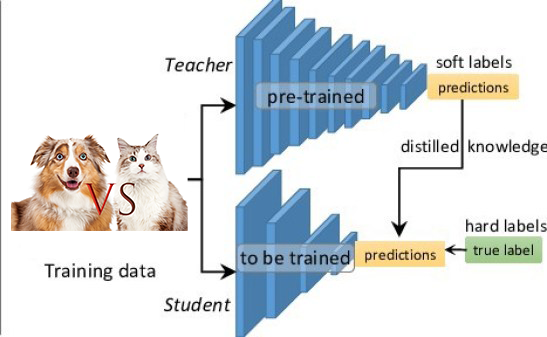

In [ ]:
mobilenetV2_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

mobilenetV2_model.add(pretrained_model)
mobilenetV2_model.add(Flatten())
mobilenetV2_model.add(Dense(512, activation='relu'))
mobilenetV2_model.add(Dense(2, activation='softmax'))

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# source : KERAS 

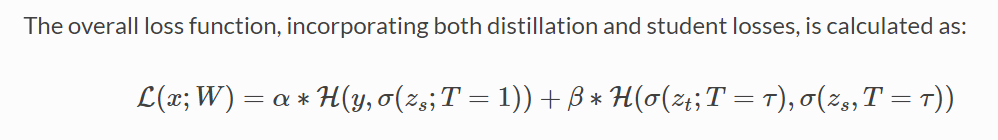

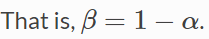

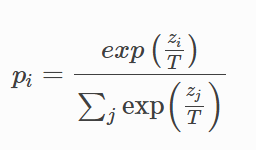

    Parameters : temperature mình chọn bằng 5 ( khi temperature = 10 nó quá soft , các giá trị khá là gần nhau )
    alpha = 0.2 ( khi alpha = 0.1 -> beta = 0.9 chủ yếu nghiêng về phần soft label )

In [ ]:
distiller = Distiller(student=mobilenetV2_model, teacher=effb4_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.categorical_crossentropy,
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=5,
)

# Distill teacher to student
distiller.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=3
)

Epoch 1/3
625/625 [==============================] - 190s 285ms/step - accuracy: 0.9475 - student_loss: 0.1381 - distillation_loss: 7.8606e-04 - val_accuracy: 0.7170 - val_student_loss: 0.7318
Epoch 2/3
625/625 [==============================] - 177s 284ms/step - accuracy: 0.9693 - student_loss: 0.0847 - distillation_loss: 4.6592e-04 - val_accuracy: 0.8712 - val_student_loss: 0.0030
Epoch 3/3
625/625 [==============================] - 178s 285ms/step - accuracy: 0.9710 - student_loss: 0.0796 - distillation_loss: 4.4302e-04 - val_accuracy: 0.8710 - val_student_loss: 0.7952


    Sau 1 epoch , ta thấy model đã cải thiện nhiều, 0.71 sau 1 epoch

## DATA AUGMENTATION , SOFT-LABEL : MIXUP

In [ ]:

class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        self.n = self.generator1.samples

    def reset_index(self):

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):

        return self.n // self.batch_size

    def __next__(self):

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [ ]:
mobilenetV2_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')

mobilenetV2_model.add(pretrained_model)
mobilenetV2_model.add(Flatten())
mobilenetV2_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mobilenetV2_model.add(Dense(2, activation='softmax'))

In [ ]:
mobilenetV2_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_34 (Flatten)        (None, 1280)              0         
                                                                 
 dense_66 (Dense)            (None, 512)               655872    
                                                                 
 dense_67 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 2,880,770
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
mobilenetV2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

batch_size = 32
validation_split = 0.2
img_height = 224
img_width = 224
epochs = 5

# Optional additional image augmentation with ImageDataGenerator.
input_imgen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0,
    shear_range=0.05,
    zoom_range=0,
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split)

input_imgen.mean = [123.68, 116.779, 103.939]

# Create training and validation generator.
train_generator = MixupImageDataGenerator(generator=input_imgen,
                                          directory=path,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')
validation_generator = input_imgen.flow_from_directory(path,
                                                       target_size=(
                                                           img_height, img_width),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset='validation')

print('training steps: ', train_generator.get_steps_per_epoch())
print('validation steps: ', validation_generator.samples // batch_size)


Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
training steps:  625
validation steps:  156


In [ ]:
distiller = Distiller(student=mobilenetV2_model, teacher=effb4_model)

In [ ]:
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.categorical_crossentropy,
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=5,
)

In [ ]:
history = distiller.fit(
 train_generator,
    steps_per_epoch=train_generator.get_steps_per_epoch(),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=1 
)

625/625 [==============================] - 685s 1s/step - accuracy: 0.9280 - student_loss: 0.2850 - distillation_loss: 0.0010 - val_accuracy: 0.8550 - val_student_loss: 0.3906


     Mình thử nhiều lần, kết quả cuối cùng cao hơn nhiều, nhưng mức độ ổn định trong các epoch đầu thì không ổn định, về sau tốt hơn 

     Mình chạy lần cuối 1 epochs để bớt tốn thời gian 
     Val_accuracy 0.855 trên epoch 1 tốt hơn nhiều với không augmentation data



---



---



---

# **ACTIVE LEARNING**

In [ ]:
!unzip "/content/drive/MyDrive/active_learing_catdog.zip"

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import random
import os
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
from torchvision import utils, models

In [ ]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [ ]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path, transform=None, test=False):
        '''
        Args:
        - dir_path (string): path to the directory containing images
        - transform (torchvision.transforms.) (default=None)
        - test (boolean): True for labeled images, False otherwise (default=False)
        '''

        self.dir_path = dir_path
        self.transform = transform
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path):
            image_filenames += [os.path.join(dirpath, file) for file in filenames if is_image(file)]
        self.image_filenames = image_filenames    
        
        # We assume that in the beginning, the entire dataset is unlabeled, unless it is flagged as 'test':
        if test:
            # The image's label is given by 0 if folder name is cat and other is dog
            # E.g. the label for the image file `/content/general_backbone/toydata/image_classification/test/cat/cat.0.jpg` is cat
            self.labels = [0 if f.split('/')[-2] == 'cat' else 1 for f in self.image_filenames]
            self.unlabeled_mask = np.zeros(len(self.image_filenames))
        else:
            self.labels =[0]*len(self.image_filenames)
            self.unlabeled_mask = np.ones(len(self.image_filenames))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], idx
    
    # Display the image [idx] and its filename
    def display(self, idx):
        img_name = self.image_filenames[idx]
        print(img_name)
        img=mpimg.imread(img_name)
        imgplot = plt.imshow(img)
        plt.show()
        return
    
    # Set the label of image [idx] to 'new_label'
    def update_label(self, idx, new_label):
        self.labels[idx] = new_label
        self.unlabeled_mask[idx] = 0
        return
    
    # Set the label of image [idx] to that read from its filename
    def label_from_filename(self, idx):
        #self.labels[idx] = int(self.image_filenames[idx][len(self.dir_path)+1])
        self.labels[idx] = 0 if self.image_filenames[idx].split('/')[-2] == 'dog' else 1
        self.unlabeled_mask[idx] = 0
        return

In [ ]:
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

In [ ]:
def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

In [ ]:
def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]

In [ ]:
'''
Queries the oracle (user, if `interactive` is set to True) for  labels for'query_size' 
samples using 'query_strategy'

Arguments:
- model (torch.nn.Module)
- device: torch.device (CPU or GPU)
- dataset (torch.utils.data.DataSet)
- query_size (int): number of samples to be queried for labels (default=10)
- query_strategy (string): one of ['random', 'least_confidence', 'margin'], 
                           otherwise defaults to 'random'
- interactive (bool): if True, prompts the user to input the images' labels manually
                      if False, reads the labels from filenames (default=True)
- pool_size (int): when > 0, the size of the randomly selected pool from the unlabeled_loader to consider
                   (otherwise defaults to considering all of the associated data)
- batch_size (int): default=128
- num_workers (int): default=4

Modifies:
- dataset: edits the labels of samples that have been queried; updates dataset.unlabeled_mask
'''

def query_the_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=True, pool_size=0, batch_size=128, num_workers=4):
    
    unlabeled_idx = np.nonzero(dataset.unlabeled_mask)[0]
    
    # Select a pool of samples to query from
    if pool_size > 0:    
        pool_idx = random.sample(range(1, len(unlabeled_idx)), pool_size)
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx[pool_idx]))
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx))
       
    if query_strategy == 'margin':
        sample_idx = margin_query(model, device, pool_loader, query_size)
    elif query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)
    
    # Query the samples, one at a time
    for sample in sample_idx:
        
        if interactive:
            dataset.display(sample)
            print("What is the class of this image?")
            new_label = int(input("\n\n> "))
            dataset.update_label(sample, new_label)
            
        else:
            dataset.label_from_filename(sample)

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in train_loader:
        
        data, target, _ = batch
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss

In [ ]:
def test(model, device, test_loader, criterion, display=False):
    
    model.eval()
    
    test_loss = 0
    n_correct = 0
    
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    
    with torch.no_grad():
        for batch in test_loader:
            
            data, target, _ = batch
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True)
 
            torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            n_correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) 
    
    if display:
        print('Accuracy on the test set: ', (100. * n_correct / len(test_loader.dataset)))
    return test_loss, (100. * n_correct / len(test_loader.dataset))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train set size:  20000
Test set size:  80
Accuracy on the test set:  50.0
/content/active_learing_catdog/train/dogs/dog.9321.jpg


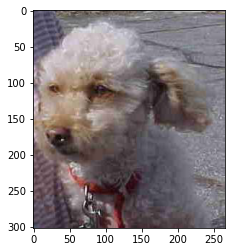

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.6711.jpg


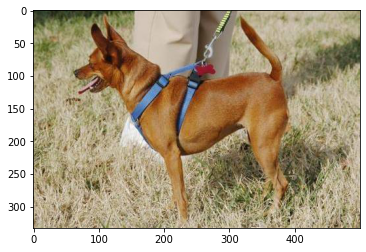

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.3187.jpg


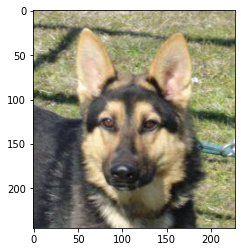

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.2412.jpg


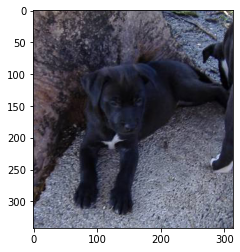

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.1626.jpg


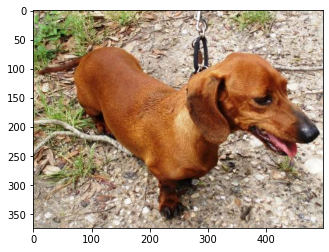

What is the class of this image?


> 0
Accuracy on the test set:  50.0
/content/active_learing_catdog/train/dogs/dog.2407.jpg


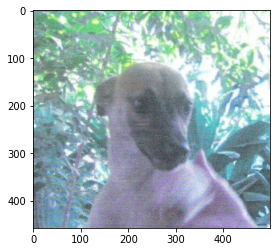

What is the class of this image?


> 0
/content/active_learing_catdog/train/cats/cat.6655.jpg


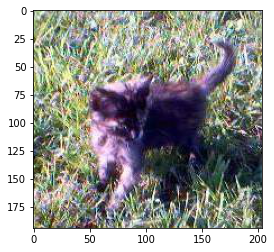

What is the class of this image?


> 1
/content/active_learing_catdog/train/dogs/dog.2358.jpg


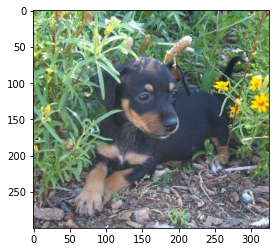

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.9952.jpg


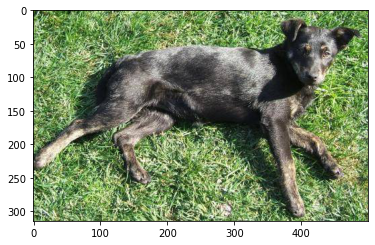

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.182.jpg


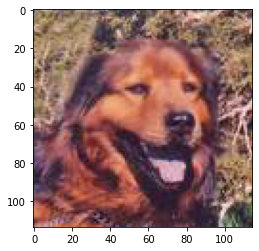

What is the class of this image?


> 0
Accuracy on the test set:  50.0
/content/active_learing_catdog/train/dogs/dog.7797.jpg


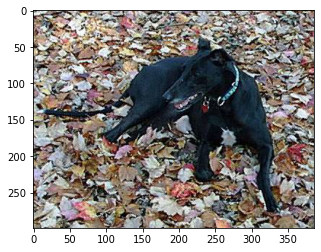

What is the class of this image?


> 0
/content/active_learing_catdog/train/cats/cat.6792.jpg


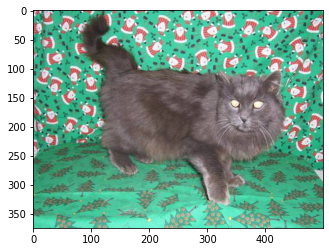

What is the class of this image?


> 1
/content/active_learing_catdog/train/dogs/dog.3911.jpg


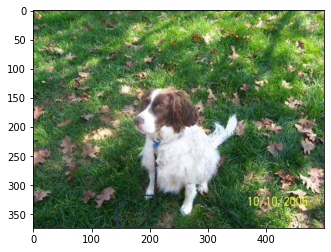

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.4843.jpg


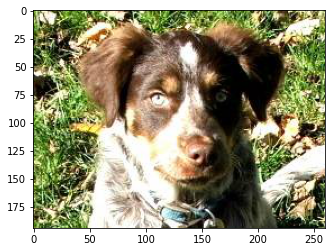

What is the class of this image?


> 0
/content/active_learing_catdog/train/dogs/dog.7523.jpg


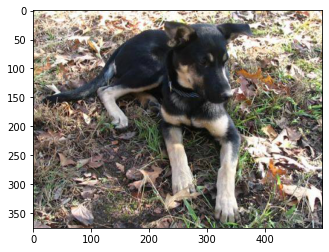

What is the class of this image?


> 0
Accuracy on the test set:  50.0


In [ ]:
np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)

train_dir = '/content/active_learing_catdog/train'
test_dir = '/content/active_learing_catdog/test'

device = torch.device("cuda")

train_set = IndexedDataset(train_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]))
test_set = IndexedDataset(test_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]), test=True) 
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=10)

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

# Number of classes in the classification problem
n_classes = 2

# The classifier is a pre-trained ResNet18 with a random top layer dim = n_classes
classifier = models.resnet18(pretrained=True)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, n_classes)
classifier = classifier.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
        
# Label the initial subset
query_the_oracle(classifier, device, train_set, query_size=20, interactive=False, query_strategy='random', pool_size=0)
  
# How many times should the oracle be queried
num_queries = 3

batch_size = 1024

# Pre-train on the initial subset
labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=10, 
                            sampler=SubsetRandomSampler(labeled_idx))
previous_test_acc = 0
current_test_acc = 1
while current_test_acc > previous_test_acc:
    previous_test_acc = current_test_acc
    train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
    _, current_test_acc = test(classifier, device, test_loader, criterion)


test(classifier, device, test_loader, criterion, display=True)

for query in range(num_queries):
    
    # Query the oracle for more labels
    query_the_oracle(classifier, device, train_set, query_size=5, query_strategy='margin', interactive=True, pool_size=0)
    
    # Train the model on the data that has been labeled so far:
    labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
    labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=10, 
                                sampler=SubsetRandomSampler(labeled_idx))
    previous_test_acc = 0
    current_test_acc = 1
    while current_test_acc > previous_test_acc:
        previous_test_acc = current_test_acc
        train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
        _, current_test_acc = test(classifier, device, test_loader, criterion)


    # Test the model:
    test(classifier, device, test_loader, criterion, display=True)

Bài trên thực hiện lại theo bài mẫu củacủa a Khánh


Có nhiều strategies khác nhau như `least confidence` `margin` `entropy` ( thuộc loại uncertainty sampling)   ... hoặc `model-based` `outliers` `cluster-based`...( thuộc loại Diversity Sampling )

Bài trên chọn margin 

Model thì lấy baseline ResNetResNet và random FCN

Label lúc đầu random, sau đó chọn dựa theo MARGIN

3 lần  truy vấn, mỗi lần lấy 5 dựa trên uncertainty của chúng


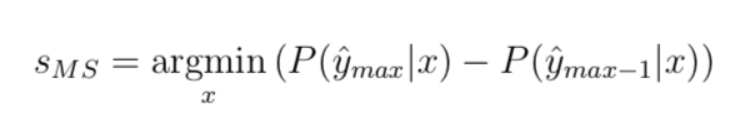